In [1]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import pandas as pd
import calendar
import numpy as np
from tslearn.metrics import dtw as ts_dtw  # Import DTW from tslearn
from fastdtw import fastdtw  # Import fastDTW from fastdtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [3]:
#Dit is voor de algehele tijdspan


url = 'https://raw.githubusercontent.com/Sebasleen/Seminargroup/Seminar/managed_portfolios_anom_d_50.csv'
df = pd.read_csv(url)

#drop the rme & re_ew columns
df.drop(columns=['rme', 're_ew'], inplace=True)

#Store the date column to readd later
dates_column = df['date']

# Drop the "date" column from the DataFrame
df.drop(columns=['date'], inplace=True)

# Replace NaN values with 0
df.fillna(0, inplace=True)

# Select only the columns containing numerical data
numerical_columns = df.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Re-add the "date" column to the DataFrame
df['date'] = dates_column

# Now, df contains scaled numerical data with the specified columns dropped and the "date" column re-added
print(df)

# Calculate z-scores for each numerical column
z_scores = (df[numerical_columns] - df[numerical_columns].mean()) / df[numerical_columns].std()

# Define a threshold for outlier detection (e.g., 3 or -3)
threshold = 3

# Identify outliers based on z-scores
outliers = (z_scores > threshold) | (z_scores < -threshold)

# Print the rows containing outliers
print("Rows with potential outliers:")
print(df[outliers.any(axis=1)])
#
## Perform K-means clustering
#kmeans = KMeans(n_clusters=7, random_state=42)  # Adjust the number of clusters as needed
#clusters = kmeans.fit_predict(X_scaled)
#
## Add cluster labels to the DataFrame
#df['Cluster'] = clusters
#
## Plot clusters for the first two principal components (for visualization purposes)
#plt.figure(figsize=(8, 6))
#for cluster in sorted(df['Cluster'].unique()):
#    cluster_points = X_scaled[clusters == cluster]
#    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
#
#plt.title('K-means Clustering')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
#plt.legend()
#plt.show()
#
## Print cluster centers (centroid)
#print("Cluster Centers:")
#print(pd.DataFrame(kmeans.cluster_centers_, columns=factors))
#
## Print cluster sizes
#print("Cluster Sizes:")
#print(df['Cluster'].value_counts())


         r_size   r_value    r_prof  r_valprof  r_fscore  r_debtiss  \
0      0.076486  0.023008  0.454666   0.225538 -0.392670  -0.004996   
1      0.066029 -0.315550  0.862036   0.158780 -0.207106  -0.004996   
2     -0.008066 -0.144767  0.710404   0.551203  0.133047  -0.004996   
3      0.679741 -0.315771 -0.693114  -0.926206  0.879686  -0.004996   
4     -0.336249  0.330552  0.119246   0.239538 -1.292301  -0.004996   
...         ...       ...       ...        ...       ...        ...   
13714  0.010236  0.160122 -0.167471   0.200234 -0.370632   0.166741   
13715 -0.135746 -0.034072  0.444317   0.412213 -0.676394   0.257063   
13716  0.057643 -0.438445  0.251517  -0.390031  0.121045   0.433827   
13717 -0.150469  0.224346 -0.697869  -0.209917 -0.349258  -0.083990   
13718  0.373120  0.063045 -0.076882  -0.252004  0.075554  -0.900423   

       r_repurch   r_nissa  r_accruals  r_growth  ...  r_betaarb  r_season  \
0      -0.026409  0.554885    0.449014  0.096185  ...   0.004475  0.1

In [196]:
print(df.columns.shape)

(50,)


In [192]:
# Convert the 'date' column to datetime if it's not already in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index of the DataFrame
df.set_index('date', inplace=True)

# Resample the DataFrame to a monthly frequency
df = df.resample('M').mean()  # Resample to monthly frequency and calculate mean

# Interpolate missing values to fill gaps (e.g., forward fill, backward fill, or interpolate)
df.interpolate(method='linear', inplace=True)  # Linear interpolation for filling missing values


KeyError: 'date'

In [7]:
#Dit runnen kost ongeveer 15 minuten dus doe maar niet te vaak

from joblib import Parallel, delayed
import sys

# Define a function to compute DTW distance between a pair of time series
def compute_dtw_distance(series1, series2):
    dtw_dist, _ = fastdtw(series1, series2)  # Compute DTW distance
    return dtw_dist

# Function to compute DTW distances in parallel with progress tracking
def compute_dtw_distances_parallel(df_resampled):
    # Initialize distance matrix
    dtw_distances = np.zeros((len(df_resampled), len(df_resampled)))
    
    # Define the number of parallel jobs (adjust as needed)
    num_jobs = -1  # Use all available CPU cores
    
    # Compute DTW distances in parallel
    total_pairs = len(df_resampled) * len(df_resampled)
    progress_step = total_pairs // 1000  # Update progress every 0.1%
    progress_count = 0
    
    print("Computing DTW distances:")
    
    for i in range(len(df_resampled)):
        for j in range(len(df_resampled)):
            # Compute DTW distance between the ith and jth time series
            dtw_dist, _ = fastdtw(df_resampled.iloc[i], df_resampled.iloc[j])  # Use fastDTW for efficiency
            dtw_distances[i, j] = dtw_dist
            
            # Print progress at regular intervals
            progress_count += 1
            if progress_count % progress_step == 0:
                progress = progress_count / total_pairs * 100
                sys.stdout.write("\rProgress: {:.1f}%".format(progress))
                sys.stdout.flush()
    
    # Reshape the results into a matrix
    dtw_distances = np.array(dtw_distances).reshape(len(df_resampled), len(df_resampled))
    
    return dtw_distances

# Calculate DTW distances between pairs of time series in parallel with progress tracking
dtw_distances = compute_dtw_distances_parallel(df)

# Print a newline after completion
print()

# Print the DTW distances matrix
print("DTW Distances Matrix:")
print(dtw_distances)

# Print the shape of the DTW distances matrix
print("Shape of DTW Distances Matrix:")
print(dtw_distances.shape)

# Calculate average DTW distance across all pairs
avg_dtw_distance = np.mean(dtw_distances)
print("Average DTW Distance:", avg_dtw_distance)

Computing DTW distances:
Progress: 99.9%
DTW Distances Matrix:
[[0.         2.14434221 2.81928387 ... 4.00862482 4.15664788 4.75262003]
 [2.14434221 0.         3.37004737 ... 4.23094999 4.76106289 4.72580765]
 [2.81928387 3.37004737 0.         ... 4.58142419 4.64384702 5.02129907]
 ...
 [4.00862482 4.23094999 4.58142419 ... 0.         4.8070892  5.35828779]
 [4.15664788 4.76106289 4.64384702 ... 4.8070892  0.         5.08028778]
 [4.75262003 4.72580765 5.02129907 ... 5.35828779 5.08028778 0.        ]]
Shape of DTW Distances Matrix:
(654, 654)
Average DTW Distance: 9.649543358914569


In [159]:
from sklearn.cluster import AgglomerativeClustering

# Initialize Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=50)

# Fit the model to the DTW distances matrix and predict clusters
agg_labels = agg_clustering.fit_predict(dtw_distances)

# Print cluster labels
print("Cluster Labels:")
print(agg_labels)

# Print the number of clusters
n_clusters_agg = len(set(agg_labels))
print("Estimated number of clusters:", n_clusters_agg)



# Assuming df contains your original data with each row representing a data point

# Create a DataFrame to store cluster profiles
cluster_profiles = pd.DataFrame(columns=range(n_clusters_agg), index=df.columns)

# Iterate over unique cluster labels
for cluster_label in range(n_clusters_agg):
    # Select data points belonging to the current cluster
    cluster_data = df[agg_labels == cluster_label]
    
    # Compute summary statistics (e.g., mean) for each feature within the cluster
    cluster_summary = cluster_data.mean()  # You can use other functions like median, std, etc.
    
    # Assign the cluster summary to the corresponding column in the cluster profiles DataFrame
    cluster_profiles[cluster_label] = cluster_summary

# Transpose the cluster profiles DataFrame for better readability
cluster_profiles = cluster_profiles.T

# Print cluster profiles
print("Cluster Profiles:")
print(cluster_profiles)



Cluster Labels:
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10  3 10  3  3 10 10 38 10 10 10 10  5  1 10  5 10 10 10 10  3
 10 10 10 10 10 10  5  3 10 18 10  5  5 10 10 10 10 10 10 10 10 10 10 10
 10 36 10 10 10 10  3  3  3  9  3 10 10 10  1 10 10 10  3 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10  3 10 10 10  3  3  3 10 14 10 10
 32 10  3 10 17 14  2 10 10 10 10  3  6 10 17 39 10 10  4 18  5 10 10 10
 10 10 10 10 10 10 36 36 10 10 10 10 10 10 10 10 10 10  3 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 30 36 10 10 10 10 10 10 10
 10 10 10 10 36 10 10 10  2  3 10 10  6 10 36 10 27  3 41 10 10 10 10 14
  3 10  3 36 10 10  3  9 10 10 10 10 10 10 10  3 36 10  3 10 10 10 10 10
  3 10 10 14 10 10 14 10 10 10 10 10 10  3  5 10 10 10  5 10  3  3 10 10
 10 10 10 10 10 10 10 10 10 10 10 10  5 38  3 10 10 10 10 36 10 10 10 10
 10 10 10 40 10 18  5 36 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 1

1. Calculate weights for each factor in each cluster: Multiply the Sharpe ratio of each cluster by the factor weights within that cluster. This gives you a weighted score for each factor in each cluster, reflecting both the importance of the factor within the cluster and its risk-adjusted return.
2. Combine factor weights across clusters: Sum up the weighted scores for each factor across all clusters. This gives you an overall score for each factor, taking into account its importance and risk-adjusted return across all clusters.
3. Construct portfolios: Based on the combined factor scores, construct portfolios with monthly rebalancing by selecting the top-performing factors. You can apply a threshold or use optimization techniques to determine the number of factors to include in each portfolio.
4. Evaluate portfolio performance: Use PLS regression or other methods to evaluate the performance of the constructed portfolios and assess their accuracy in achieving investment goals.

How would this incorporate the monthly rebalancing given that our data is from 1963 till 2019?

To incorporate monthly rebalancing into the process, you would follow these steps:
* 		Define the rebalancing frequency: Determine that you want to rebalance your portfolios monthly.
* 		Set the rebalancing dates: Define the specific dates on which you will rebalance the portfolios each month. These dates could be the last trading day of each month or any other date that suits your strategy.
* 		Calculate factor weights and construct portfolios on rebalancing dates: On each rebalancing date, follow the steps outlined earlier to calculate factor weights and construct portfolios based on the data available up to that date. This ensures that you're using the most up-to-date information to make investment decisions.
* 		Hold the portfolios until the next rebalancing date: Once you construct the portfolios, hold them until the next rebalancing date without making any changes, even if market conditions change.
* 		Repeat the process monthly: On each subsequent rebalancing date, repeat the process of calculating factor weights and constructing portfolios based on the latest available data.
By following this approach, you ensure that your portfolios are regularly updated to reflect changes in market conditions and factor performance, while still adhering to your monthly rebalancing schedule. This helps maintain the effectiveness of your investment strategy over time.

* 		Calculate weights for each factor in each cluster: Multiply the Sharpe ratio of each cluster by the factor weights within that cluster. This gives you a weighted score for each factor in each cluster, reflecting both the importance of the factor within the cluster and its risk-adjusted return.
* 		Combine factor weights across clusters: Sum up the weighted scores for each factor across all clusters. This gives you an overall score for each factor, taking into account its importance and risk-adjusted return across all clusters.
* 		Construct portfolios: Based on the combined factor scores, construct portfolios with monthly rebalancing by selecting the top-performing factors. You can apply a threshold or use optimization techniques to determine the number of factors to include in each portfolio.
* 		Evaluate portfolio performance: Use PLS regression or other methods to evaluate the performance of the constructed portfolios and assess their accuracy in achieving investment goals.

How would this incorporate the monthly rebalancing given that our data is from 1963 till 2019?

To incorporate monthly rebalancing into the process, you would follow these steps:
* 		Define the rebalancing frequency: Determine that you want to rebalance your portfolios monthly.
* 		Set the rebalancing dates: Define the specific dates on which you will rebalance the portfolios each month. These dates could be the last trading day of each month or any other date that suits your strategy.
* 		Calculate factor weights and construct portfolios on rebalancing dates: On each rebalancing date, follow the steps outlined earlier to calculate factor weights and construct portfolios based on the data available up to that date. This ensures that you're using the most up-to-date information to make investment decisions.
* 		Hold the portfolios until the next rebalancing date: Once you construct the portfolios, hold them until the next rebalancing date without making any changes, even if market conditions change.
* 		Repeat the process monthly: On each subsequent rebalancing date, repeat the process of calculating factor weights and constructing portfolios based on the latest available data.
By following this approach, you ensure that your portfolios are regularly updated to reflect changes in market conditions and factor performance, while still adhering to your monthly rebalancing schedule. This helps maintain the effectiveness of your investment strategy over time.


The rebalancing frequency would be monthly.
the rebalancing dates would be the end of every month running from july 1973 untill december 2019.

We then would need to calculate factor weights and construct porfolios on rebalancing dates right.

Which would lead to the 2 steps given before:

1. calculate weights for reach factor in each cluster and
2. combine factor weights across clusters.

How do we do step 1?


To calculate the weights for each factor in each cluster, you can follow these steps:
* 		Normalize the factor values: First, normalize the factor values within each cluster to ensure that factors with different scales are comparable. You can use z-score normalization or min-max scaling.
* 		Calculate factor weights: Once the factor values are normalized, calculate the factor weights for each cluster. You can use various methods such as principal component analysis (PCA), factor analysis, or linear regression to derive factor weights.
* 		Combine factor weights: After obtaining factor weights for each cluster, combine them across clusters. You can use the Sharpe ratios of each cluster as weights to combine the factor weights. This will give more weight to clusters with higher Sharpe ratios, indicating better risk-adjusted performance.
* 		Normalize combined factor weights: Normalize the combined factor weights to ensure that they sum up to 1. These normalized weights represent the relative importance of each factor in the overall portfolio construction process.





In [201]:
#Stap 1: normalize the factor values within each cluster
from sklearn.preprocessing import MinMaxScaler

# Assuming cluster_profiles is your DataFrame containing the cluster profiles
# Extracting the factor columns for normalization
factor_columns = cluster_profiles.columns[:-1]  # Exclude the last column (Sharpe Ratio)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data (compute minimum and maximum for scaling)
scaler.fit(cluster_profiles[factor_columns])

# Transform and normalize the factor values
cluster_profiles_normalized = cluster_profiles.copy()  # Create a copy of the original DataFrame
cluster_profiles_normalized[factor_columns] = scaler.transform(cluster_profiles[factor_columns])

# Print the normalized cluster profiles
print("Normalized Cluster Profiles:")
print(cluster_profiles_normalized)


Normalized Cluster Profiles:
      r_size   r_value    r_prof  r_valprof  r_fscore  r_debtiss  r_repurch  \
0   0.555636  0.541039  0.325614   0.510044  0.459025   0.409936   0.653077   
1   0.558943  0.293301  0.474788   0.314807  0.348978   0.491737   0.490704   
2   0.649090  0.466606  0.364718   0.486151  0.462442   0.445925   0.620994   
3   0.618395  0.483686  0.303739   0.413079  0.407667   0.425066   0.570696   
4   0.599879  0.565007  0.325015   0.589841  0.399475   0.364664   0.610626   
5   0.625691  0.480734  0.277537   0.400082  0.398681   0.438240   0.571335   
6   0.622281  0.397858  0.487559   0.378306  0.428717   0.432482   0.553135   
7   0.653532  0.635165  0.225227   0.632518  0.543871   0.373320   0.682887   
8   0.535547  0.670129  0.205623   0.607824  0.503254   0.338489   0.714472   
9   0.635687  0.588571  0.259218   0.535489  0.476397   0.405135   0.597904   
10  0.605143  0.449935  0.348230   0.404018  0.398889   0.434097   0.556618   
11  1.000000  0.618400 

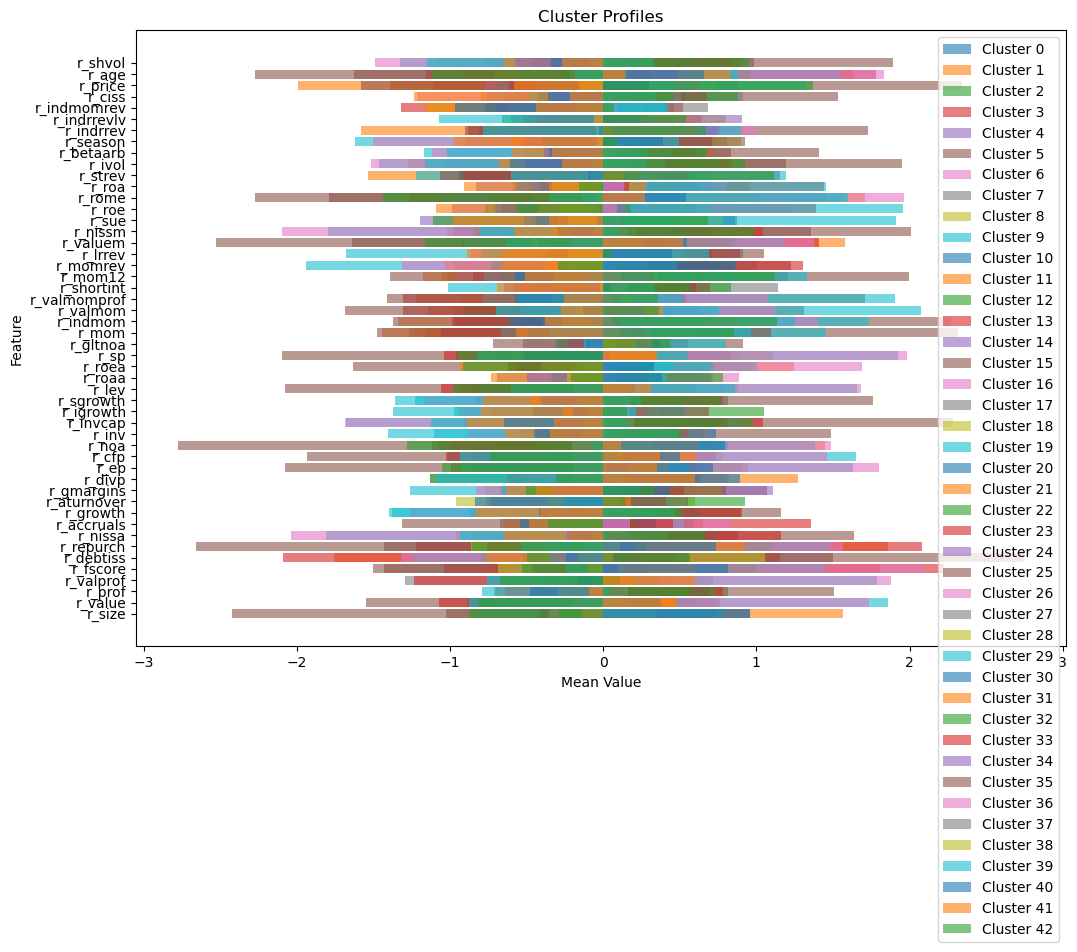

In [165]:
# Plotting cluster profiles as bar plots
plt.figure(figsize=(12, 8))

# Iterate over each cluster
for cluster_label in range(n_clusters_agg):
    # Select data points belonging to the current cluster
    cluster_data = df[agg_labels == cluster_label]
    
    # Compute the mean value of each feature within the cluster
    cluster_means = cluster_data.mean()
    
    # Plot the bar plot for the current cluster
    plt.barh(cluster_means.index, cluster_means.values, label=f'Cluster {cluster_label}', alpha=0.6)

plt.xlabel('Mean Value')
plt.ylabel('Feature')
plt.title('Cluster Profiles')
plt.legend()
plt.show()


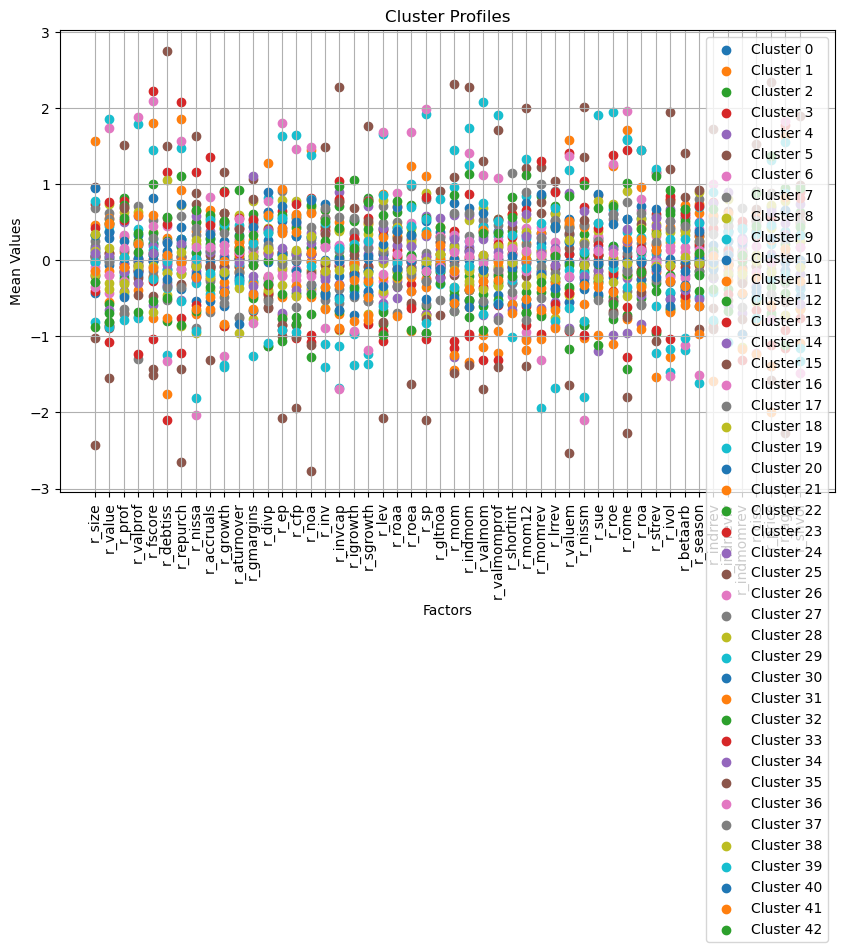

In [168]:
import matplotlib.pyplot as plt

# Assuming cluster_profiles is your DataFrame containing the cluster profiles
# cluster_profiles = cluster_profiles.T  # Transpose if necessary

# Plotting cluster profiles
plt.figure(figsize=(10, 6))
for cluster_label in range(len(cluster_profiles)):
    plt.scatter(cluster_profiles.columns, cluster_profiles.iloc[cluster_label], label=f'Cluster {cluster_label}')
plt.xlabel('Factors')
plt.ylabel('Mean Values')
plt.title('Cluster Profiles')
plt.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


In [219]:
import numpy as np

# Assuming you have cluster_profiles DataFrame containing the mean returns and standard deviations for each cluster
# Compute the Sharpe ratios for each cluster
sharpe_ratios = cluster_profiles.mean(axis=1) / cluster_profiles.std(axis=1)

# Add the Sharpe ratios as a new column in the cluster profiles DataFrame
cluster_profiles['Sharpe Ratio'] = sharpe_ratios

print(cluster_profiles_normalized)

      r_size   r_value    r_prof  r_valprof  r_fscore  r_debtiss  r_repurch  \
0   0.555636  0.541039  0.325614   0.510044  0.459025   0.409936   0.653077   
1   0.558943  0.293301  0.474788   0.314807  0.348978   0.491737   0.490704   
2   0.649090  0.466606  0.364718   0.486151  0.462442   0.445925   0.620994   
3   0.618395  0.483686  0.303739   0.413079  0.407667   0.425066   0.570696   
4   0.599879  0.565007  0.325015   0.589841  0.399475   0.364664   0.610626   
5   0.625691  0.480734  0.277537   0.400082  0.398681   0.438240   0.571335   
6   0.622281  0.397858  0.487559   0.378306  0.428717   0.432482   0.553135   
7   0.653532  0.635165  0.225227   0.632518  0.543871   0.373320   0.682887   
8   0.535547  0.670129  0.205623   0.607824  0.503254   0.338489   0.714472   
9   0.635687  0.588571  0.259218   0.535489  0.476397   0.405135   0.597904   
10  0.605143  0.449935  0.348230   0.404018  0.398889   0.434097   0.556618   
11  1.000000  0.618400  0.039489   0.386843  0.88806

In [178]:
# Normalize Sharpe ratios to obtain weights
weights = sharpe_ratios / sharpe_ratios.sum()

# Print the weights for each cluster
print("Weights for Each Cluster:")
print(weights)


Weights for Each Cluster:
0    -0.181444
1    -0.178368
2     0.606867
3     0.092719
4     0.230320
5     0.611112
6     0.012550
7    -0.223308
8    -0.203153
9    -0.132560
10   -0.128506
11    0.006800
12    0.062415
13   -0.107367
14   -0.003058
15   -0.199866
16   -0.494042
17    0.321947
18   -0.201827
19   -0.127444
20   -0.690821
21    0.540026
22   -0.018658
23   -0.080254
24   -0.183156
25    0.042727
26   -0.202443
27   -0.395087
28   -0.092776
29   -0.148834
30    0.590771
31    0.203846
32    0.098710
33    0.177826
34    0.027203
35    0.271665
36   -0.274241
37    0.177110
38    0.564384
39    0.231706
40   -0.019874
41    0.524699
42   -0.108315
dtype: float64


In [188]:
import pandas as pd

# Assuming you have factor weights per factor within each cluster stored in a DataFrame called factor_weights
# factor_weights should have clusters as rows, factors as columns, and the values as factor weights

# Assuming you have Sharpe ratios for each cluster stored in a Series called sharpe_ratios
# sharpe_ratios should have clusters as index and Sharpe ratios as values

# Multiply factor weights by Sharpe ratios to obtain weighted factor weights for each cluster
weighted_factor_weights = factor_weights.mul(sharpe_ratios, axis=0)

# Print the resulting weighted factor weights DataFrame
print("Weighted Factor Weights per Cluster:")
print(weighted_factor_weights)


NameError: name 'factor_weights' is not defined

In [186]:
# Check the dimensions of monthly_returns

print(weights.shape)
print("Dimensions of monthly_returns:", monthly_returns.shape)

# Check the dimensions of cluster_mean_returns
print("Dimensions of cluster_mean_returns:", cluster_mean_returns.shape)


(43,)
Dimensions of monthly_returns: (653, 50)
Dimensions of cluster_mean_returns: (43, 50)


In [182]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression

def calculate_monthly_returns(df):
    """
    Calculate monthly returns from the DataFrame containing dates as index
    and asset returns as columns.
    """
    return df.pct_change().dropna()

def perform_pls_regression(X_train, y_train, n_components=1):
    """
    Perform Partial Least Squares (PLS) regression.
    """
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train, y_train)
    return pls

def calculate_weights(sharpe_ratios):
    """
    Calculate weights based on Sharpe ratios.
    """
    # Normalize Sharpe ratios to sum up to 1
    weights = sharpe_ratios / sum(sharpe_ratios)
    return weights

def rebalance_portfolio(df, weights):
    """
    Rebalance portfolio based on assigned weights.
    """
    # Multiply each asset return by its corresponding weight
    portfolio_returns = df.iloc[:, :-1] @ weights
    
    # Calculate cumulative returns
    cumulative_returns = (portfolio_returns + 1).cumprod()
    return cumulative_returns
# Calculate monthly returns
monthly_returns = calculate_monthly_returns(df.set_index(df.index))

# Assuming cluster_profiles DataFrame contains the mean returns and standard deviations for each cluster
# Extract mean returns for each cluster
cluster_mean_returns = cluster_profiles.iloc[:, :-1]

# Perform PLS regression for each cluster
pls_models = {}
for cluster_label in range(len(cluster_mean_returns)):
    pls_model = perform_pls_regression(monthly_returns, cluster_mean_returns.iloc[cluster_label])
    pls_models[cluster_label] = pls_model

# Calculate Sharpe ratios for each cluster
sharpe_ratios = cluster_profiles['Sharpe Ratio']

# Assign weights to clusters based on Sharpe ratios
weights = calculate_weights(sharpe_ratios)

# Rebalance portfolio using assigned weights
portfolio_returns = rebalance_portfolio(monthly_returns, weights)

# Print portfolio returns
print(portfolio_returns)


ValueError: Found input variables with inconsistent numbers of samples: [653, 50]

In [ ]:
#Dit is yearly

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read data from URL
url = 'https://raw.githubusercontent.com/Sebasleen/Seminargroup/Seminar/managed_portfolios_anom_d_50.csv'
df = pd.read_csv(url)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set 'date' column as the index
df.set_index('date', inplace=True)

# Replace missing values with 0
df.fillna(0, inplace=True)

# Define relevant factors
factors = [
    'r_size', 'r_value', 'r_prof', 'r_valprof', 'r_fscore',
    'r_debtiss', 'r_repurch', 'r_nissa', 'r_accruals', 'r_growth', 'r_aturnover',
    'r_gmargins', 'r_divp', 'r_ep', 'r_cfp', 'r_noa', 'r_inv', 'r_invcap',
    'r_igrowth', 'r_sgrowth', 'r_lev', 'r_roaa', 'r_roea', 'r_sp', 'r_gltnoa',
    'r_indmom', 'r_valmom', 'r_valmomprof', 'r_shortint', 'r_mom12', 'r_momrev',
    'r_lrrev', 'r_valuem', 'r_nissm', 'r_sue', 'r_roe', 'r_rome', 'r_roa',
    'r_strev', 'r_ivol', 'r_betaarb', 'r_season', 'r_indrrev', 'r_indrrevlv',
    'r_indmomrev', 'r_ciss', 'r_price', 'r_age', 'r_shvol'
]

# Initialize a list to store the cluster centers
cluster_centers_list = []

# Initialize a dictionary to store the cluster sizes
cluster_sizes_dict = {}

# Set the starting date
start_date = pd.to_datetime('1973-07-31')

# Iterate over each year
for year, year_data in df.groupby(df.index.year):
    # Skip years before the starting date
    if year < start_date.year:
        continue

    # Extract relevant features for the current year
    X = year_data[factors]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=7, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # Store cluster centers
    cluster_centers_list.append(kmeans.cluster_centers_)

    # Store cluster sizes
    cluster_sizes_dict[year] = pd.Series(clusters).value_counts()

    # Plot clusters for the first two principal components
    plt.figure(figsize=(8, 6))
    for cluster in range(7):
        cluster_points = X_scaled[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

    plt.title(f'K-means Clustering for Year {year}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Print cluster centers for each year
for i, centers in enumerate(cluster_centers_list, start=start_date.year):
    print(f"Cluster Centers for Year {i}:")
    print(pd.DataFrame(centers, columns=factors))

# Print cluster sizes for each year
for year, sizes in cluster_sizes_dict.items():
    print(f"Cluster Sizes for Year {year}:")
    print(sizes)


In [ ]:
#Dit is met Hierarchial Clustering
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read data from URL
url = 'https://raw.githubusercontent.com/Sebasleen/Seminargroup/Seminar/managed_portfolios_anom_d_50.csv'
df = pd.read_csv(url)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set 'date' column as the index
df.set_index('date', inplace=True)

# Replace missing values with 0
df.fillna(0, inplace=True)

# Define relevant factors
factors = [
    'r_size', 'r_value', 'r_prof', 'r_valprof', 'r_fscore',
    'r_debtiss', 'r_repurch', 'r_nissa', 'r_accruals', 'r_growth', 'r_aturnover',
    'r_gmargins', 'r_divp', 'r_ep', 'r_cfp', 'r_noa', 'r_inv', 'r_invcap',
    'r_igrowth', 'r_sgrowth', 'r_lev', 'r_roaa', 'r_roea', 'r_sp', 'r_gltnoa',
    'r_indmom', 'r_valmom', 'r_valmomprof', 'r_shortint', 'r_mom12', 'r_momrev',
    'r_lrrev', 'r_valuem', 'r_nissm', 'r_sue', 'r_roe', 'r_rome', 'r_roa',
    'r_strev', 'r_ivol', 'r_betaarb', 'r_season', 'r_indrrev', 'r_indrrevlv',
    'r_indmomrev', 'r_ciss', 'r_price', 'r_age', 'r_shvol'
]

# Initialize a list to store the cluster sizes
cluster_sizes_dict = {}

# Set the starting date
start_date = pd.to_datetime('1973-07-31')

# Iterate over each year
for year, year_data in df.groupby(df.index.year):
    # Skip years before the starting date
    if year < start_date.year:
        continue

    # Extract relevant features for the current year
    X = year_data[factors]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform Hierarchical Agglomerative Clustering
    hac = AgglomerativeClustering(n_clusters=5)  # Adjust the number of clusters as needed
    clusters = hac.fit_predict(X_scaled)

    # Store cluster sizes
    cluster_sizes_dict[year] = pd.Series(clusters).value_counts()

    # Plot clusters for the first two principal components
    plt.figure(figsize=(8, 6))
    for cluster in range(5):  # Adjust the number of clusters as needed
        cluster_points = X_scaled[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

    plt.title(f'Hierarchical Agglomerative Clustering for Year {year}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Print cluster sizes for each year
for year, sizes in cluster_sizes_dict.items():
    print(f"Cluster Sizes for Year {year}:")
    print(sizes)




In [ ]:
#Dit is voor beide Hierarchial Agglomerative Clustering and K-Means

import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read data from URL
url = 'https://raw.githubusercontent.com/Sebasleen/Seminargroup/Seminar/managed_portfolios_anom_d_50.csv'
df = pd.read_csv(url)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set 'date' column as the index
df.set_index('date', inplace=True)

# Replace missing values with 0
df.fillna(0, inplace=True)

# Define relevant factors
factors = [
    'r_size', 'r_value', 'r_prof', 'r_valprof', 'r_fscore',
    'r_debtiss', 'r_repurch', 'r_nissa', 'r_accruals', 'r_growth', 'r_aturnover',
    'r_gmargins', 'r_divp', 'r_ep', 'r_cfp', 'r_noa', 'r_inv', 'r_invcap',
    'r_igrowth', 'r_sgrowth', 'r_lev', 'r_roaa', 'r_roea', 'r_sp', 'r_gltnoa',
    'r_indmom', 'r_valmom', 'r_valmomprof', 'r_shortint', 'r_mom12', 'r_momrev',
    'r_lrrev', 'r_valuem', 'r_nissm', 'r_sue', 'r_roe', 'r_rome', 'r_roa',
    'r_strev', 'r_ivol', 'r_betaarb', 'r_season', 'r_indrrev', 'r_indrrevlv',
    'r_indmomrev', 'r_ciss', 'r_price', 'r_age', 'r_shvol'
]

# Set the starting date
start_date = pd.to_datetime('1973-07-31')

# Initialize subplots
fig, axs = plt.subplots(len(df.index.year.unique()), 3, figsize=(18, len(df.index.year.unique()) * 6))

# Iterate over each year
for i, (year, year_data) in enumerate(df.groupby(df.index.year)):
    # Skip years before the starting date
    if year < start_date.year:
        continue

    # Extract relevant features for the current year
    X = year_data[factors]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans_clusters = kmeans.fit_predict(X_scaled)

    # Perform Hierarchical Agglomerative Clustering
    hac = AgglomerativeClustering(n_clusters=10)  # Adjust the number of clusters as needed
    hac_clusters = hac.fit_predict(X_scaled)

    # Plot clusters for K-means
    axs[i, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_clusters, cmap='inferno', alpha=0.5)
    axs[i, 0].set_title(f'K-means Clustering for Year {year}')
    axs[i, 0].set_xlabel('Principal Component 1')
    axs[i, 0].set_ylabel('Principal Component 2')

    # Plot clusters for HAC
    axs[i, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=hac_clusters, cmap='spring', alpha=0.5)
    axs[i, 1].set_title(f'Hierarchical Agglomerative Clustering for Year {year}')
    axs[i, 1].set_xlabel('Principal Component 1')
    axs[i, 1].set_ylabel('Principal Component 2')

    # Plot differences
    kmeans_labels = pd.Series(kmeans_clusters, name='K-means')
    hac_labels = pd.Series(hac_clusters, name='HAC')
    comparison = pd.concat([kmeans_labels, hac_labels], axis=1)
    comparison['Difference'] = comparison['K-means'] - comparison['HAC']
    axs[i, 2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=comparison['Difference'], cmap='coolwarm', alpha=0.5)
    axs[i, 2].set_title(f'Differences between K-means and HAC for Year {year}')
    axs[i, 2].set_xlabel('Principal Component 1')
    axs[i, 2].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [ ]:
file_url = 'https://raw.githubusercontent.com/Sebasleen/Seminargroup/Seminar/US%20Factors/anomalies.dta'

# Read the Stata file content
Anomalies = pd.read_stata(file_url)

# Display unique values in the 'anomaly' column
print(Anomalies['anomaly'].unique())

#Hier heb ik de global factors verwijderd
column_name = 'anomaly'
values_to_dropUS = ['glbab', 'glcma', 'glhml', 'glqmj', 'glrmw', 'glsmb', 'glumd']
ElementsUS = Anomalies[column_name].isin(values_to_dropUS)
Anomalies_US = Anomalies[~ElementsUS]

column_name = 'anomaly'
values_to_dropGF = ['ac', 'bab', 'cfp', 'cma', 'ep', 'hml', 'liq', 'ltrev', 'nsi', 'qmj', 'rmw', 'rvar',
'smb', 'strev', 'umd']
ElementsGF = Anomalies[column_name].isin(values_to_dropGF)
Anomalies_GF = Anomalies[~ElementsGF]

#Dit zijn dus alle 15 factors die alleen bij de US horen. 
print(Anomalies_US)

#En dit zijn alle 7 global factors
print(Anomalies_GF)

# Convert 'year' and 'month' columns to datetime for US factors
Anomalies_US = Anomalies_US.copy()
Anomalies_US['date'] = pd.to_datetime(Anomalies_US['year'].astype(str) + '-' + Anomalies_US['month'].astype(str).str.zfill(2))
Anomalies_US = Anomalies_US.drop(columns=['year', 'month'])

# Convert 'year' and 'month' columns to datetime for Global factors
Anomalies_GF = Anomalies_GF.copy()
Anomalies_GF['date'] = pd.to_datetime(Anomalies_GF['year'].astype(str) + '-' + Anomalies_GF['month'].astype(str).str.zfill(2))
Anomalies_GF = Anomalies_GF.drop(columns=['year', 'month'])

# Define the desired column order
desired_columns_order = ["anomaly", "date", "ret", "time", "global"]

# Reorder the columns in the US factors DataFrame
Anomalies_US = Anomalies_US.reindex(columns=desired_columns_order)

# Reorder the columns in the Global factors DataFrame
Anomalies_GF = Anomalies_GF.reindex(columns=desired_columns_order)

Anomalies_US.drop(columns=['global'], inplace=True)
Anomalies_GF.drop(columns=['global'], inplace=True)


# Display the updated DataFrames
print("US Factors:")
print(Anomalies_US)

print("\nGlobal Factors:")
print(Anomalies_GF)


In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming Anomalies_GF DataFrame is already loaded and preprocessed

# Convert 'date' column to ordinal numbers
Anomalies_US['date_ordinal'] = pd.to_datetime(Anomalies_US['date']).apply(lambda x: x.toordinal())

# Extract relevant numerical features for clustering
numerical_features = Anomalies_US[['date_ordinal', 'ret']]

# Exclude 'date_ordinal' from the numerical features to be standardized
numerical_features_for_scaling = Anomalies_US[['ret']]

# Standardize the numerical features (excluding 'date_ordinal')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features_for_scaling)

# Perform hierarchical clustering
n_clusters = 15  # Choose the number of clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = agglomerative_clustering.fit_predict(scaled_features)

# Add cluster labels to the DataFrame
Anomalies_US['Cluster'] = clusters

# Display the DataFrame with cluster labels
print(Anomalies_US)

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_points = Anomalies_US[clusters == cluster]
    plt.scatter(cluster_points['date_ordinal'], cluster_points['ret'], label=f'Cluster {cluster}')

plt.title('Clusters Visualization')
plt.xlabel('date_ordinal')
plt.ylabel('ret')
plt.legend()
plt.show()

# Print cluster statistics
for cluster in range(n_clusters):
    cluster_data = Anomalies_US[Anomalies_US['Cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data.describe())
    print("\n")


In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Anomalies_GF DataFrame is already loaded and preprocessed

# Convert 'date' column to ordinal numbers
Anomalies_US['date_ordinal'] = pd.to_datetime(Anomalies_US['date']).apply(lambda x: x.toordinal())

# One-hot encode the 'anomaly' column
encoder = OneHotEncoder()
anomaly_encoded = encoder.fit_transform(Anomalies_US[['anomaly']])

# Combine one-hot encoded anomaly with numerical features
features = pd.concat([Anomalies_US[['date_ordinal', 'ret']], pd.DataFrame(anomaly_encoded.toarray(), columns=encoder.get_feature_names_out(['anomaly']))], axis=1)

# Exclude 'date_ordinal' from the numerical features to be standardized
numerical_features_for_scaling = Anomalies_US[['ret']]

# Standardize the numerical features (excluding 'date_ordinal')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features_for_scaling)

# Perform hierarchical clustering
n_clusters = 15  # Choose the number of clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = agglomerative_clustering.fit_predict(scaled_features)

# Determine the most common anomaly in each cluster
cluster_names = {}
for cluster in range(n_clusters):
    cluster_data = Anomalies_US[clusters == cluster]
    most_common_anomaly = cluster_data['anomaly'].value_counts().idxmax()
    cluster_names[cluster] = most_common_anomaly

# Add cluster names to the DataFrame
Anomalies_US['Cluster'] = [cluster_names[cluster] for cluster in clusters]

# Display the DataFrame with cluster labels
print(Anomalies_US)

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in cluster_names.keys():
    cluster_points = Anomalies_US[clusters == cluster]
    plt.scatter(cluster_points['date_ordinal'], cluster_points['ret'], label=f'Cluster {cluster_names[cluster]}')

plt.title('Clusters Visualization')
plt.xlabel('date_ordinal')
plt.ylabel('ret')
plt.legend()
plt.show()


# Determine the anomalies present in each cluster
cluster_anomalies = {}
for cluster in range(n_clusters):
    cluster_data = Anomalies_US[clusters == cluster]
    cluster_anomalies[cluster] = cluster_data['anomaly'].unique()

# Display anomalies present in each cluster
for cluster, anomalies in cluster_anomalies.items():
    print(f"Cluster {cluster_names[cluster]}:")
    print(anomalies)
    print()

# Create boxplots for each feature within each cluster
plt.figure(figsize=(10, 5*len(features.columns)))

# Plot data distribution for each feature within each cluster
for i, feature in enumerate(features.columns):
    sns.boxplot(data=features, x=clusters, y=feature)
    plt.title(f'Data Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming Anomalies_GF DataFrame is already loaded and preprocessed

# Convert 'date' column to ordinal numbers
Anomalies_GF['date_ordinal'] = pd.to_datetime(Anomalies_GF['date']).apply(lambda x: x.toordinal())

# Extract relevant numerical features for clustering
numerical_features = Anomalies_GF[['date_ordinal', 'ret']]

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Perform hierarchical clustering
n_clusters = 7  # Choose the number of clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = agglomerative_clustering.fit_predict(scaled_features)

# Add cluster labels to the DataFrame
Anomalies_GF['Cluster'] = clusters
# Add cluster names to the DataFrame
# Determine the most common anomaly in each cluster
cluster_names = {}
for cluster in range(n_clusters):
    cluster_data = Anomalies_GF[clusters == cluster]
    most_common_anomaly = cluster_data['anomaly'].value_counts().idxmax()
    cluster_names[cluster] = most_common_anomaly

Anomalies_GF['Cluster'] = [cluster_names[cluster] for cluster in clusters]

# Display the DataFrame with cluster labels
print(Anomalies_GF)

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in cluster_names.keys():
    cluster_points = scaled_features[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_names[cluster]}')

plt.title('Clusters Visualization')
plt.xlabel('date_ordinal')
plt.ylabel('ret')
plt.legend()
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_points = numerical_features[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title('Clusters Visualization')
plt.xlabel('ret')
plt.ylabel('time')
plt.legend()
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import numpy as np

# Load your dataset into a DataFrame (assuming it's already loaded)
# If not loaded, load it using pd.read_csv(), pd.read_excel(), or pd.read_stata() depending on the file format

# Assuming your DataFrame is named 'df'

# Perform agglomerative hierarchical clustering
# Specify the number of clusters you want
n_clusters = 3
agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Fit the model to your data
clusters = agglomerative_clustering.fit_predict(df)

# Plot dendrogram (optional but useful for visualizing hierarchy)
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Using features from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
# Call the dendrogram function to plot the dendrogram
plot_dendrogram(agglomerative_clustering, labels=agglomerative_clustering.labels_)
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Add the cluster labels to your DataFrame
df['Cluster'] = clusters


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Anomalies_GF DataFrame is already loaded and preprocessed

# Convert 'date' column to ordinal numbers
Anomalies_US['date_ordinal'] = pd.to_datetime(Anomalies_US['date']).apply(lambda x: x.toordinal())

# One-hot encode the 'anomaly' column
encoder = OneHotEncoder()
anomaly_encoded = encoder.fit_transform(Anomalies_US[['anomaly']])

# Combine one-hot encoded anomaly with numerical features
features = pd.concat([Anomalies_US[['date_ordinal', 'ret']], pd.DataFrame(anomaly_encoded.toarray(), columns=encoder.get_feature_names_out(['anomaly']))], axis=1)

# Exclude 'date_ordinal' from the numerical features to be standardized
numerical_features_for_scaling = Anomalies_US[['ret']]

# Standardize the numerical features (excluding 'date_ordinal')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features_for_scaling)

# Perform k-means clustering
n_clusters = 15  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(scaled_features)

# Determine the most common anomaly in each cluster
cluster_names = {}
for cluster in range(n_clusters):
    cluster_data = Anomalies_US[clusters == cluster]
    most_common_anomaly = cluster_data['anomaly'].value_counts().idxmax()
    cluster_names[cluster] = most_common_anomaly

# Add cluster names to the DataFrame
Anomalies_US['Cluster'] = [cluster_names[cluster] for cluster in clusters]

# Display the DataFrame with cluster labels
print(Anomalies_US)

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in cluster_names.keys():
    cluster_points = scaled_features[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_names[cluster]}')

plt.title('Clusters Visualization')
plt.xlabel('date_ordinal')
plt.ylabel('ret')
plt.legend()
plt.show()

# Determine the anomalies present in each cluster
cluster_anomalies = {}
for cluster in range(n_clusters):
    cluster_data = Anomalies_US[clusters == cluster]
    cluster_anomalies[cluster] = cluster_data['anomaly'].unique()

# Display anomalies present in each cluster
for cluster, anomalies in cluster_anomalies.items():
    print(f"Cluster {cluster_names[cluster]}:")
    print(anomalies)
    print()

# Create boxplots for each feature within each cluster
plt.figure(figsize=(10, 5*len(features.columns)))

# Plot data distribution for each feature within each cluster
for i, feature in enumerate(features.columns):
    sns.boxplot(data=features, x=clusters, y=feature)
    plt.title(f'Data Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()
